## Basic Pipeline for image processing of our CNN 

### Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os

In [215]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.math import confusion_matrix

In [216]:
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical

In [4]:
from sklearn.model_selection import train_test_split

### Import for large model with csv

#### Create Dataframe of Data 

In [225]:
directory_no_mask = '../raw_data/Dataset/without_mask/'

no_mask_names = os.listdir(directory_no_mask)

no_mask_df = pd.DataFrame()
no_mask_df['file_name'] = no_mask_names
no_mask_df['file_name'] = directory_no_mask + no_mask_df['file_name']
no_mask_df['label'] = 0

In [226]:
no_mask_df.shape

(2994, 2)

In [227]:
directory_wrong_mask = '../raw_data/Dataset/mask_weared_incorrect/'

wrong_mask_names = os.listdir(directory_wrong_mask)

wrong_mask_df = pd.DataFrame()
wrong_mask_df['file_name'] = wrong_mask_names
wrong_mask_df['file_name'] = directory_wrong_mask + wrong_mask_df['file_name']
wrong_mask_df['label'] = 1

In [220]:
wrong_mask_df.shape

(2994, 2)

In [221]:
directory_with_mask = '../raw_data/Dataset/with_mask/'

with_mask_names = os.listdir(directory_with_mask)

with_mask_df = pd.DataFrame()
with_mask_df['file_name'] = with_mask_names
with_mask_df['file_name'] = directory_with_mask + with_mask_df['file_name']
with_mask_df['label'] = 2

In [222]:
with_mask_df.shape

(2995, 2)

In [12]:
df = pd.concat([no_mask_df,wrong_mask_df,with_mask_df])

In [13]:
df.shape

(8983, 2)

In [14]:
df.head()

,file_name,label
0,../raw_data/Dataset/without_mask/348.png,0
1,../raw_data/Dataset/without_mask/1804.png,0
2,../raw_data/Dataset/without_mask/1810.png,0
3,../raw_data/Dataset/without_mask/1186.png,0
4,../raw_data/Dataset/without_mask/412.png,0


#### Create Train, Test, Val Set 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0], df.iloc[:,1:], test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [16]:
def read_img(image_file, label):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_image(image, channels = 3, dtype = tf.float32)
    image = tf.image.resize_with_pad(image, 224, 224)
     #image = image / 255.
    return image, label 

In [17]:
y_cat_train = to_categorical(y_train, num_classes=3)
y_cat_val = to_categorical(y_val, num_classes=3)
y_cat_test = to_categorical(y_test, num_classes=3)
y_cat_train.shape

(6467, 3)

In [18]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train.values , y_cat_train))
ds_train = ds_train.map(read_img).batch(32)

2021-09-09 10:18:27.707059: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
ds_val = tf.data.Dataset.from_tensor_slices((X_val.values, y_cat_val))
ds_val = ds_val.map(read_img).batch(32)

In [20]:
ds_test = tf.data.Dataset.from_tensor_slices((X_test.values, y_cat_test))
ds_test = ds_test.map(read_img).batch(32)

### Agumentation for Images (Just in Case)

### Scale the Images

In [ ]:
# not necessary with the current image import
#X.scaled = X / 255

### Built a basic CNN just like in class

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', padding='valid', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(4, kernel_size=(3), padding='valid', activation='relu')) # kernel_size = 3 <==> (3, 3)
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax')) 

model.summary() 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
history =model.fit(ds_train, epochs = 10, validation_data = ds_val, callbacks = [es])

In [ ]:
model.evaluate(ds_test, verbose=0)

In [ ]:
save_path = ('../models')
model.save(save_path)

In [74]:
save_path = ('../models')
model = tf.keras.models.load_model(save_path)

In [ ]:
model.summary()

### Transfer learning with a suitable network

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

#### MobileNetV2

In [ ]:
base_model_1 = MobileNetV2(weights="imagenet", include_top=False,input_shape = (224,224,3)) 
base_model_1.trainable = False


In [ ]:
pooling = layers.MaxPool2D(pool_size=(2,2))
flatten_layer = layers.Flatten()
dense_1 = layers.Dense(128, activation="relu")
drop_1 = layers.Dropout(0.5)
prediction_1 = layers.Dense(3, activation="softmax")

In [ ]:
model1 = models.Sequential([
    base_model_1,
    pooling, 
    flatten_layer,
    dense_1,
    drop_1,
    prediction_1
])

In [ ]:
model1.summary()

In [ ]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
es = EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
history_1 = model1.fit(ds_train, epochs = 10, validation_data = ds_val, callbacks = [es])

In [ ]:
model1.evaluate(ds_test)

In [ ]:
save_path = ('../models/Model_1')
model1.save(save_path)

In [79]:
save_path = ('../models/model_1.1')
model1 = tf.keras.models.load_model(save_path)

In [ ]:
# Fit the model
# list all data in history
# summarize history for accuracy
plt.title("Training Loss and Accuracy")
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

In [ ]:
prediction_proba_m1 = model1.predict(ds_test)

In [ ]:
prediction_m1 = prediction_proba_m1.argmax(axis = 1)

In [ ]:
print(confusion_matrix(y_test, prediction_m1))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, prediction_m1))

#### NASNetMobile

In [ ]:
from tensorflow.keras.applications import NASNetMobile

In [ ]:
base_model_2 = NASNetMobile(
    input_shape= None,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,)
base_model_2.trainable = False
base_model.summary()

In [ ]:
dense_layer = layers.Dense(500, activation = 'relu')
prediction_layer = layers.Dense(3, activation = 'softmax')

model2 = models.Sequential([
    base_model_2, 
    prediction_layer
])

In [ ]:
model2.summary()

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model2.fit(ds_train, epochs = 10, validation_data = ds_val, callbacks = [es])

In [ ]:
model2.evaluate(ds_test)

In [ ]:
[0.5263108015060425, 0.5971062779426575]

In [ ]:
prediction_m2 = model2.predict(ds_test)

In [ ]:
confusion_matrix(y_test, prediction_m2)

### Face recognition

In [23]:
import tensorflow as tf
import cv2
import mtcnn
import os
from PIL import Image

In [38]:
def load_picture(path_to_file):
    img = tf.io.read_file(path_to_file)
    img = tf.image.decode_image(pixels, channels = 3, dtype = tf.float32)
    img = img.numpy()
    return img
    

In [128]:
detector = mtcnn.MTCNN(steps_threshold=[0.8, 0.8, 0.8])
def detect_faces(img):
    faces= detector.detect_faces(img*255)
    return faces

In [ ]:
def face_from_coordinates(img,x,y,w,h):
    return img[y:y+h,x:x+w]

In [37]:
def face_cropping(faces, img):
    encoded_faces = []
    for index, face in enumerate(faces):
        encoded_faces.append(face_from_coordinates(img, *face['box']))
    return encoded_faces

In [26]:
def prep_prediction_multi(encoded_face):
    img = tf.image.resize_with_pad(encoded_face, 224, 224)
    img= tf.expand_dims(img,0)
    return img

In [27]:
def prep_prediction_one(encoded_face):
    img = tf.image.resize_with_pad(encoded_face, 224, 224)
    #img= tf.expand_dims(img,0)
    return img

Funktion for face probability prediction 

In [80]:
def pred_mask(faces, img):
    cropped_face= face_cropping(faces, img)
    if len(cropped_face) == 1: 
        face = prep_prediction_one(cropped_face)
        return [model1.predict(face).argmax()]
    elif len(cropped_face) > 1: 
        faces = []
        for j in range(len(cropped_face)):
            face = prep_prediction_multi(cropped_face[j])
            faces.append(face)
        predictions = []
        for face in faces:
            predictions.append(model1.predict(face).argmax())
        return predictions
    else:
        return [3]
            

In [57]:
def draw_image(image, coordinates, prediction):
    color_corresp = {
      0: (255,0,0),
      1: (255,165,0),
      2: (0,255,0)}
    coordinates =[faces[i]['box'] for i in range(len(faces))]
    for i in range(len(coordinates)):
        cv2.rectangle(image,
                      (coordinates[i][0],coordinates[i][1]),
                      (coordinates[i][0]+coordinates[i][2],coordinates[i][1]+ coordinates[i][3]),
                      color_corresp[prediction[i]],3)
    plt.imshow(image)                
                   
                   

In [47]:
# load image from file
#filename = '../raw_data/face_no_mask/no_mask_marga.jpg'
filename = '../raw_data/face_with_mask/mask_marga_1.jpg'
#filename = '../raw_data/archive/images/maksssksksss4.png'
#filename = '../raw_data/Face_with_mask/Augmented_56_323581.png'
pixels = tf.io.read_file(filename) #format='jpeg')
pixels = tf.image.decode_image(pixels, channels = 3, dtype = tf.float32)
pixels = pixels.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2, 2]


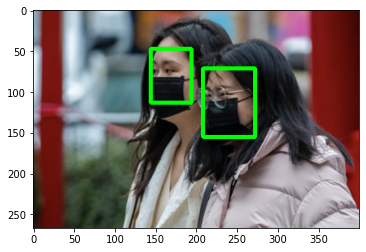

In [113]:
filename = '../raw_data/archive/images/maksssksksss31.png'
img = load_picture(filename)
faces = detect_face(img)
prediction = pred_mask(faces, img)
print(prediction)
draw_image(img, faces, prediction)

#### Create dataset of images to predict

In [235]:
#creating a test set of pictures with mask and without mask

path_mask = '../raw_data/Face_Mask_Dataset/Test/WithMask'
path_no_mask = '../raw_data/Face_Mask_Dataset/Test/WithoutMask'

#path_mask = '../raw_data/Face_with_mask'
#path_no_mask = '../raw_data/Face_no_Mask'

list_mask = os.listdir(path_mask)
list_mask.sort()


list_no_mask = os.listdir(path_no_mask)
list_no_mask.sort()

X_model_test = []
y_model_test = []

for i in range(150,400):
        c_path = os.path.join(path_mask, list_mask[i])
        X_model_test.append(plt.imread(c_path)[:, :, :])
        y_model_test.append(2) 
    

for i in range(150,400):
        c_path = os.path.join(path_no_mask, list_no_mask[i])
        X_model_test.append(plt.imread(c_path)[:, :, :])
        y_model_test.append(0) 

In [236]:
# detecting faces in each picture -- only one face per picture is correct

faces_list = []
for image in X_model_test:
    faces = detect_faces(image)
    faces_list.append(faces)
    
    

In [237]:
# sort all the pictures in which no face was detected 

faces_array = np.array(faces_list)
faces_array = faces_array[[el != [] for el in faces_list]]

X_model_test_array = np.array(X_model_test)
X_model_test_array = X_model_test_array[[el != [] for el in faces_list]]

y_model_test_array = np.array(y_model_test)
y_model_test_array=y_model_test_array[[el != [] for el in faces_list]]

number_of_detected_faces = len([el for el in faces_list if el != [] ])
number_of_missed_faces = len([el for el in faces_list if el == [] ])

/var/folders/fm/h79l0z951tj_sk_5h_0mjn7h0000gn/T/ipykernel_88525/1244963916.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  faces_array = np.array(faces_list)
/var/folders/fm/h79l0z951tj_sk_5h_0mjn7h0000gn/T/ipykernel_88525/1244963916.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X_model_test_array = np.array(X_model_test)


In [238]:
#predict wearing a mask or not 
predictions = []
for faces , img in zip(faces_array,X_model_test_array):
    predictions.append(pred_mask(faces, img))

In [239]:
#Show Pictures of more than one face
for index, el in enumerate(predictions):
    if len(el) > 1:
        print(index)
    

In [ ]:
#remove all non_existing_faces 
predictions[166].pop(1)

In [240]:
# create an np array to pass in the confusion matrix
pred_2 = []
for el in predictions:
    for e in el:
        pred_2.append(e)
pred_2 = np.array(pred_2)

In [241]:
#create the confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_model_test_array, pred_2))

[[243   3]
 [  0 181]]


In [214]:
pred_2

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])